In [1]:
import os
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from PIL import Image

torch.manual_seed(1)

Note that the Stanford Cars download link is broken for pytorch so we need to download it from Kaggle manually and place the files in the `notebooks/data/stanford_cars` folder.

We will only use a subset of the images to keep the experiments in this notebook manageable.

In [2]:
class GrayscaleToRGB:
    def __call__(self, image):
        if image.mode == "L":
            image = image.convert("RGB")
        return image


resize_transform = v2.Compose(
    [
        v2.Resize((224, 224)),
        GrayscaleToRGB(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)


class StanfordCars(torch.utils.data.Dataset):
    def __init__(self, root_path, transform=None):
        self.images = [
            os.path.join(root_path, file) for file in os.listdir(root_path)
        ]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_file = self.images[index]
        image = Image.open(image_file).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image[None].squeeze().permute(1, 2, 0)


dataset = StanfordCars(
    root_path="data/stanford_cars", transform=resize_transform
)

In [3]:
def show_images(dataset):
    figure = plt.figure(figsize=(8, 8))
    columns, rows = 5, 5
    for index in range(1, columns * rows + 1):
        sample_index = torch.randint(len(dataset), size=(1,)).item()
        image = dataset[sample_index]
        figure.add_subplot(rows, columns, index)
        plt.axis("off")
        plt.imshow(image, cmap="gray")
        plt.tight_layout()
    plt.show()

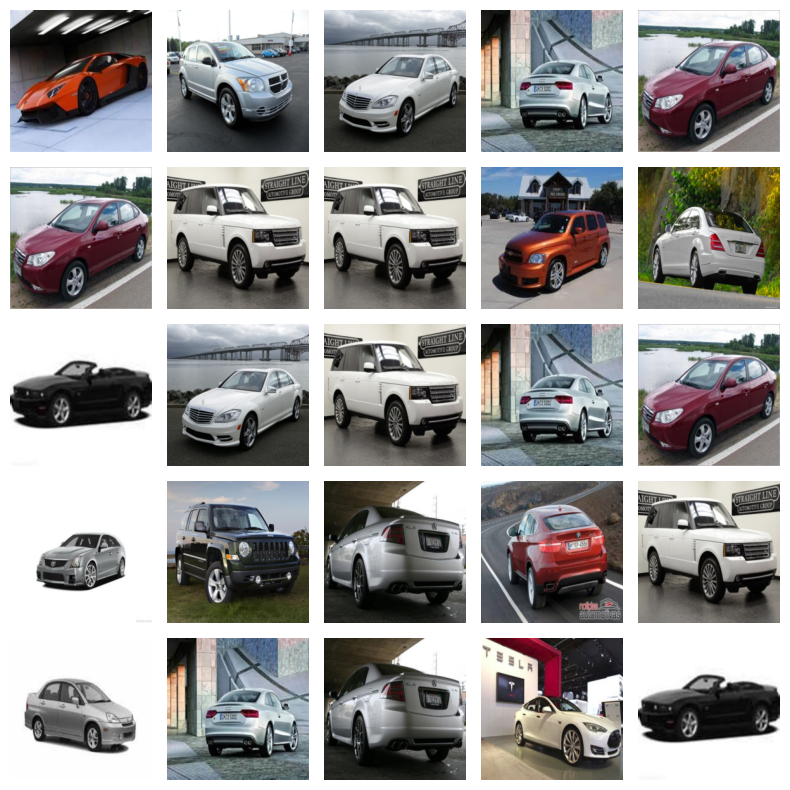

In [4]:
show_images(dataset)

In [5]:
import pybsm.simulation as simulation

In [6]:
import copy


def apply_camera_distortion(image, f, D, bit_depth=100):
    p = 0.008e-3
    opt_trans_wavelengths = np.array([0.58 - 0.08, 0.58 + 0.08]) * 1.0e-6
    ihaze = 1
    altitude = 9000
    ground_range = 1000
    gsd_meters_per_px = 0.02
    image_array = np.array(image)
    reference_image = simulation.RefImage(image_array, gsd=gsd_meters_per_px)
    scenario = simulation.Scenario(
        "virtual_camera1", ihaze, altitude, ground_range=ground_range
    )
    sensor = simulation.Sensor(
        "virtual_camera1", D, f, p, opt_trans_wavelengths, bit_depth=bit_depth
    )
    image_out = simulation.simulate_image(reference_image, sensor, scenario)[2]
    image_out = simulation.stretch_contrast_convert_8bit(image_out)
    return image_out


class Camera1:
    def __call__(self, image):
        f = 4
        D = 275e-3
        bit_depth = 4
        image_out = apply_camera_distortion(
            copy.deepcopy(image), f, D, bit_depth=bit_depth
        )
        return image_out


class Camera2:
    def __call__(self, image):
        f = 4
        D = 275e-3
        bit_depth = 8
        image_out = apply_camera_distortion(
            copy.deepcopy(image), f, D, bit_depth=bit_depth
        )
        return image_out


transform_camera1 = v2.Compose(
    [
        v2.Resize((224, 224)),
        GrayscaleToRGB(),
        Camera1(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

transform_camera2 = v2.Compose(
    [
        v2.Resize((224, 224)),
        GrayscaleToRGB(),
        Camera2(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

/workspaces/fall-2024-class-06/.venv/lib/python3.12/site-packages/pybsm/otf/functional.py:155: RuntimeWarning: divide by zero encountered in divide
  np.arccos(rho / eta / r0)
/workspaces/fall-2024-class-06/.venv/lib/python3.12/site-packages/pybsm/otf/functional.py:155: RuntimeWarning: invalid value encountered in divide
  np.arccos(rho / eta / r0)
/workspaces/fall-2024-class-06/.venv/lib/python3.12/site-packages/pybsm/otf/functional.py:156: RuntimeWarning: divide by zero encountered in divide
  - (rho / eta / r0) * np.sqrt(1.0 - (rho / eta / r0) ** 2.0)
/workspaces/fall-2024-class-06/.venv/lib/python3.12/site-packages/pybsm/otf/functional.py:156: RuntimeWarning: invalid value encountered in divide
  - (rho / eta / r0) * np.sqrt(1.0 - (rho / eta / r0) ** 2.0)
/workspaces/fall-2024-class-06/.venv/lib/python3.12/site-packages/pybsm/otf/functional.py:164: RuntimeWarning: divide by zero encountered in divide
  phi = np.arccos((1.0 + eta**2.0 - (2.0 * rho / r0) ** 2) / 2.0 / eta)
/workspace

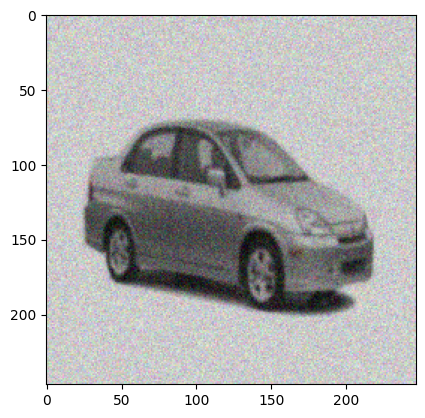

In [7]:
dataset.transform = transform_camera1

plt.figure()
image_camera1 = dataset[0]
plt.imshow(image_camera1)
plt.show()

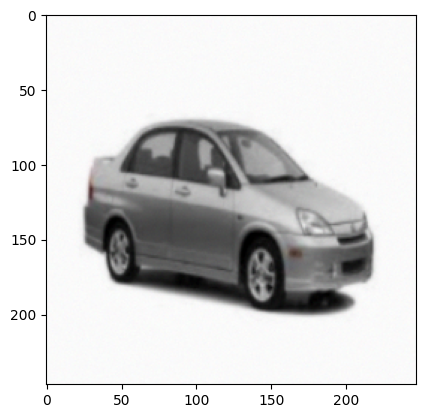

In [8]:
dataset.transform = transform_camera2

plt.figure()
image_camera2 = dataset[0]
plt.imshow(image_camera2)
plt.show()

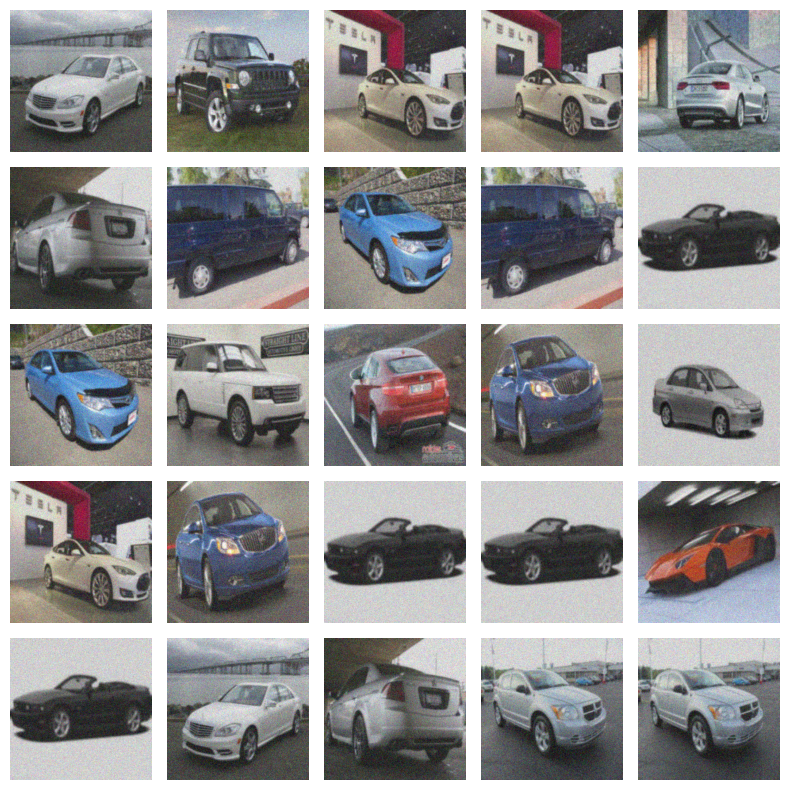

In [11]:
dataset.transform = transform_camera1
show_images(dataset)

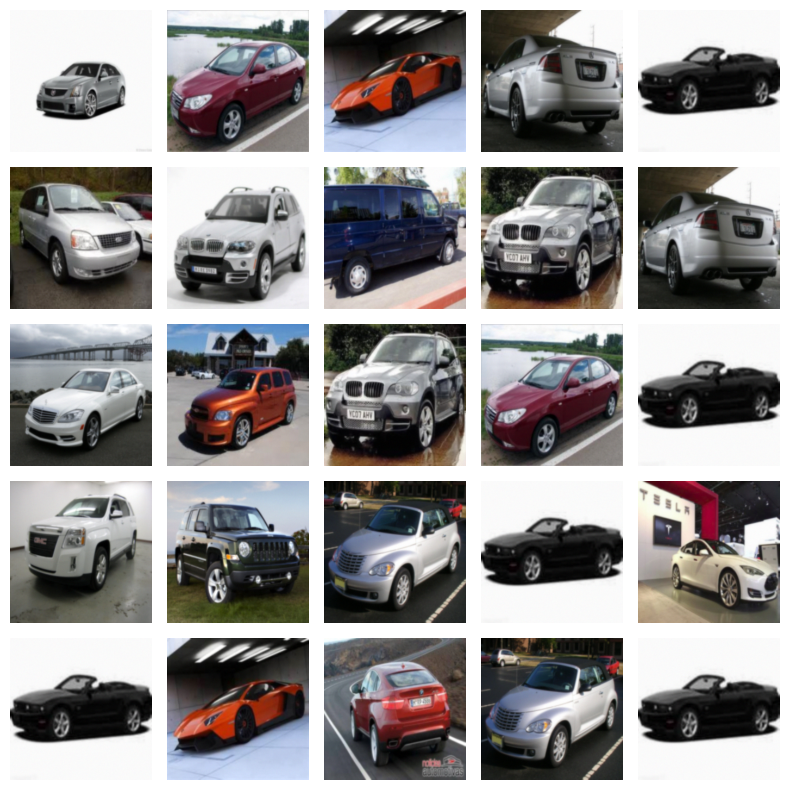

In [12]:
dataset.transform = transform_camera2
show_images(dataset)